# Feature Engineering Code-along Solution

<a href="https://colab.research.google.com/github/coding-dojo-data-science/week-10-lecture-2-feature-engineering/blob/11-7-22/SOLUTION%20Challenge%20Feature%20Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In this notebook we use the following feature engineering strategies:
1. scaling
2. binning
3. removing outliers
4. log transformation
5. target encoding
6. polynomial features

In [59]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, \
precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay, \
classification_report

import warnings
warnings.filterwarnings('ignore')

# Useful Functions

In [60]:
def eval_regression(true, pred, name='Model'):
    """Evaluates true and predicted values from a regression model.  
    Outputs a dataframe of metrics"""
    scores = pd.DataFrame()
    scores['Model Name'] = [name]
    scores['RMSE'] = [np.sqrt(mean_squared_error(true, pred))]
    scores['MAE'] = [mean_absolute_error(true, pred)]
    scores['R2'] = [r2_score(true, pred)]
    scores.set_index('Model Name', inplace=True)

    return scores

def eval_classification(true, pred, name='Model'):
    """shows classification_report and confusion matrix
    for classification model predictions.  Outputs a dataframe of metrics"""
  
    print(name, '\n')
    print(classification_report(true, pred))
    ConfusionMatrixDisplay.from_predictions(true, pred)
    plt.show()

    scores = pd.DataFrame()
    scores['Model Name'] = [name]
    scores['Precision'] = [precision_score(true, pred)]
    scores['Recall'] = [recall_score(true, pred)]
    scores['F1 Score'] = [f1_score(true, pred)]
    scores['Accuracy'] = [accuracy_score(true, pred)]
    scores.set_index('Model Name', inplace=True)

    return scores

## Data

Today we will use data about used car sales in India from Kaggle.  [Here is the source](https://www.kaggle.com/datasets/saisaathvik/used-cars-dataset-from-cardekhocom)

In [61]:
# load data
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTeFV8-y5rNxCM946otPPyTF5UZ5rIOTOHrXCYU5zkqB7DubjxGKGzaxVayeLdU0wcCqLMrhjUbgkEp/pub?gid=1641648108&single=true&output=csv')
df_backup = df.copy()

display(df.head())
print(df.shape)

,Id,year,brand,full_model_name,model_name,price,distance_travelled(kms),fuel_type,city
0,0,2016,Honda,Honda Brio S MT,Brio,425000,9680,Petrol,Mumbai
1,1,2012,Nissan,Nissan Sunny XV Diesel,Sunny,325000,119120,Diesel,Mumbai
2,2,2017,Toyota,Toyota Fortuner 2.8 4x2 MT [2016-2020],Fortuner,2650000,64593,Diesel,Thane
3,3,2017,Mercedes-Benz,Mercedes-Benz E-Class E 220d Expression [2019-...,E-Class,4195000,25000,Diesel,Mumbai
4,4,2012,Hyundai,Hyundai Verna Fluidic 1.6 CRDi SX,Verna,475000,23800,Diesel,Mumbai


(1725, 9)


## Explore and clean the data

In [62]:
# check for duplicates
df.duplicated().sum()

0

In [63]:
# remove duplicates
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [64]:
# check for missing values
df.isna().sum()

Id                         0
year                       0
brand                      0
full_model_name            0
model_name                 0
price                      0
distance_travelled(kms)    0
fuel_type                  0
city                       0
dtype: int64

In [65]:
# check summary statistics
df.describe(include='all')

,Id,year,brand,full_model_name,model_name,price,distance_travelled(kms),fuel_type,city
count,1725.000000,1725.000000,1725,1725,1725,1.725000e+03,1725.000000,1725,1725
unique,NaN,NaN,31,750,168,NaN,NaN,5,15
top,NaN,NaN,Hyundai,Ford EcoSport Titanium 1.5L TDCi,Creta,NaN,NaN,Diesel,Chennai
freq,NaN,NaN,297,12,71,NaN,NaN,922,493
mean,862.000000,2015.390725,NaN,NaN,NaN,1.494837e+06,53848.256232,NaN,NaN
std,498.108924,3.207504,NaN,NaN,NaN,1.671658e+06,44725.541963,NaN,NaN
min,0.000000,1990.000000,NaN,NaN,NaN,6.250000e+04,350.000000,NaN,NaN
25%,431.000000,2013.000000,NaN,NaN,NaN,5.450000e+05,29000.000000,NaN,NaN
50%,862.000000,2016.000000,NaN,NaN,NaN,8.750000e+05,49000.000000,NaN,NaN
75%,1293.000000,2018.000000,NaN,NaN,NaN,1.825000e+06,70500.000000,NaN,NaN


## Feature Selection
Which columns won't be useful, or might harm our model?

In [66]:
df.drop(columns=['Id','full_model_name'], inplace=True)

## Some Numeric Feature Engineering


 year 



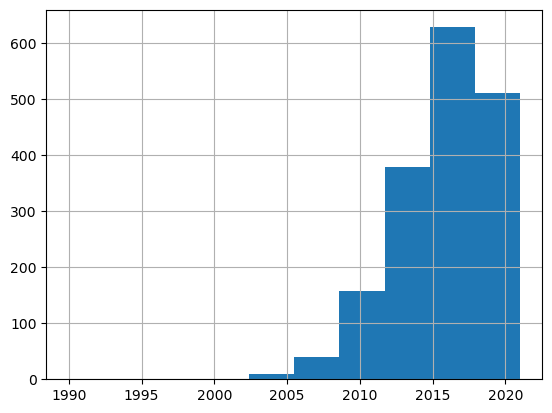


 price 



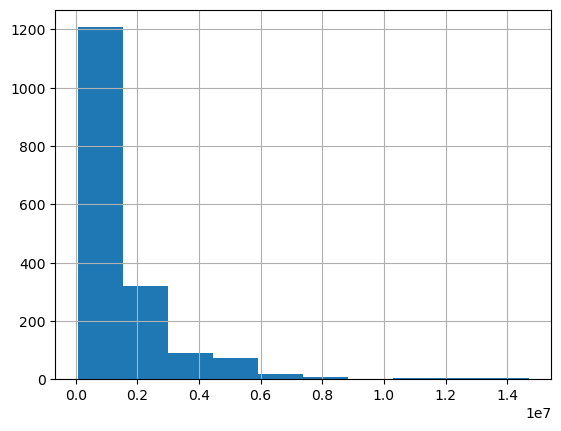


 distance_travelled(kms) 



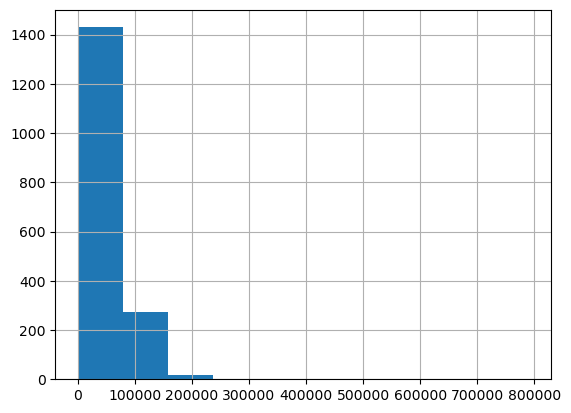

In [67]:
# explore numeric distributions
for col in df.select_dtypes('number'):
  print('\n', col, '\n')
  df[col].hist()
  plt.show()

### Filter to remove outliers

In [68]:
# check year value_counts
df['year'].value_counts().sort_index()

1990      1
2004      5
2005      5
2006      3
2007     14
2008     22
2009     27
2010     54
2011     77
2012    136
2013    104
2014    138
2015    185
2016    215
2017    228
2018    246
2019    164
2020     80
2021     21
Name: year, dtype: int64

In [69]:
# exclude cars made before 2000
df = df[df['year'] > 2000]
df['year'].value_counts()

2018    246
2017    228
2016    215
2015    185
2019    164
2014    138
2012    136
2013    104
2020     80
2011     77
2010     54
2009     27
2008     22
2021     21
2007     14
2005      5
2004      5
2006      3
Name: year, dtype: int64

## Convert year to nominal categorical

This way, if cars made in certain years are more expensive than those made in other years, the model can see this in a non-linear way.

In [70]:
# convert year to categorical
df['year'] = df['year'].astype('object')

## Transform to normalize feature

<AxesSubplot: >

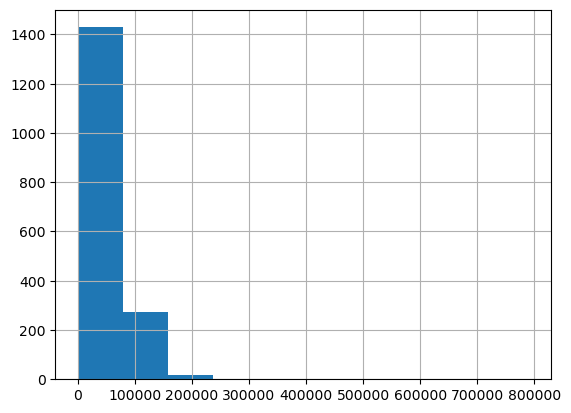

In [71]:
df['distance_travelled(kms)'].hist()

<AxesSubplot: >

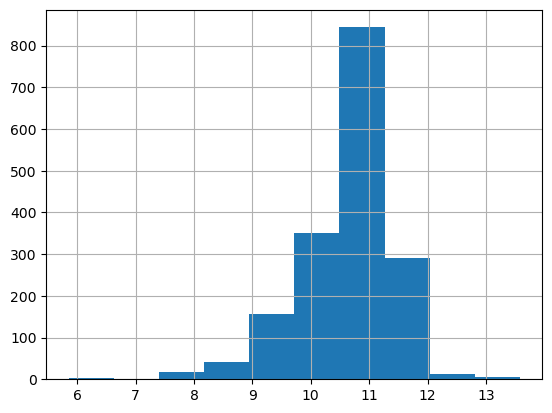

In [72]:
# log transform 'distance_travelled(kms)'
df['distance_travelled(kms)'] = np.log(df['distance_travelled(kms)'])

df['distance_travelled(kms)'].hist()

## Binning the Target: Let's change this regression problem to a binary classification problem

In [73]:
df['price'].describe()

count    1.724000e+03
mean     1.495516e+06
std      1.671905e+06
min      6.250000e+04
25%      5.450000e+05
50%      8.750000e+05
75%      1.825000e+06
max      1.470000e+07
Name: price, dtype: float64

### What's wrong with the code below?  How would you fix it?

In [74]:
# encode cars with prices above the mean as 1 and below the mean as 0

df['is_expensive'] = df['price'].apply(lambda x: 1 if x > df['price'].mean() else 0)
df['is_expensive'].value_counts()

0    1202
1     522
Name: is_expensive, dtype: int64

In [75]:
X = df.drop(columns=['price', 'is_expensive'])
y = df['price']

X_train, X_test, y_train, y_test =  train_test_split(X, y, random_state=42)

# Bin the Target

In [76]:
df['price'].head()

0     425000
1     325000
2    2650000
3    4195000
4     475000
Name: price, dtype: int64

In [77]:
mean_price = y_train.mean()

def bin_price(x):
    if x > mean_price:
        return 1
    else: 
        return 0

y_train = y_train.apply(bin_price)
y_test = y_test.apply(bin_price)

In [78]:
y_train.value_counts()

0    901
1    392
Name: price, dtype: int64

# Base Model

In [79]:
# instantiate transformers
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

cat_cols = make_column_selector(dtype_include='object')
num_cols = make_column_selector(dtype_include='number')

# create preprocessing pipeline
base_preprocess = make_column_transformer((ohe, cat_cols), (scaler, num_cols))

# Examine the results of all transformers
base_preprocess.fit_transform(X_train, y_train).shape

(1293, 226)

In [80]:
# Create and evaluate model with a base logistic regression
logreg_base = LogisticRegression(max_iter=1000)
logreg_base = make_pipeline(base_preprocess, logreg_base)
logreg_base.fit(X_train, y_train)

train_pred = logreg_base.predict(X_train)
test_pred = logreg_base.predict(X_test)

BaseTrain 

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       901
           1       0.95      0.93      0.94       392

    accuracy                           0.96      1293
   macro avg       0.96      0.95      0.96      1293
weighted avg       0.96      0.96      0.96      1293



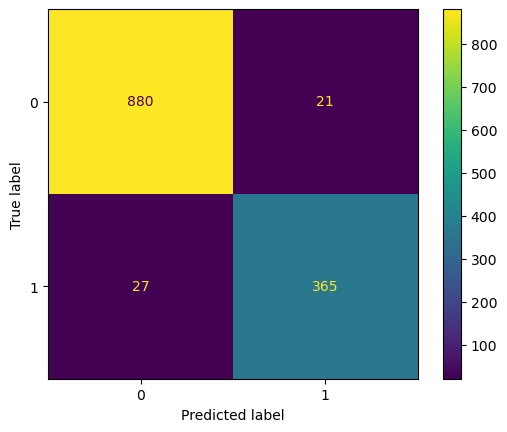

BaseTest 

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       300
           1       0.92      0.89      0.91       131

    accuracy                           0.94       431
   macro avg       0.94      0.93      0.93       431
weighted avg       0.94      0.94      0.94       431



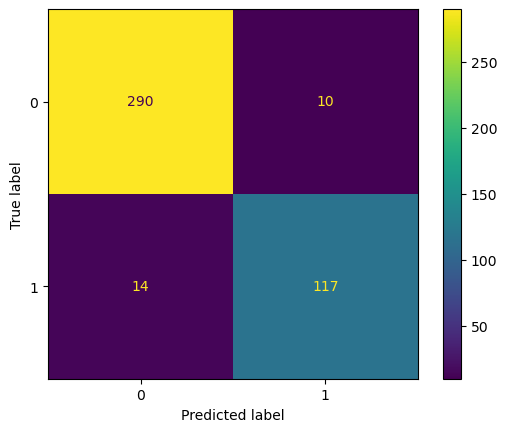

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
BaseTrain,0.945596,0.931122,0.938303,0.962877
BaseTest,0.921260,0.893130,0.906977,0.944316


In [81]:
# evaluate model
train_scores = eval_classification(y_train, train_pred, name='BaseTrain')

test_scores = eval_classification(y_test, test_pred, name='BaseTest')

base_scores = pd.concat([train_scores, test_scores])
base_scores

# Modeling: PolynomialFeatures

## Test PolynomialFeatures to see how it changes data

We are working here with the entire dataframe to illustrate how the model combines numeric features.  We won't apply the transformers until later.

In [82]:
# Scale the data
df_scaled = pd.DataFrame(scaler.fit_transform(df[['price','distance_travelled(kms)']]), 
                            columns=df[['price','distance_travelled(kms)']].columns)

# Create polynomial features
poly = PolynomialFeatures(degree=3)

poly_train = poly.fit_transform(df_scaled)
poly_train = pd.DataFrame(poly_train, columns=poly.get_feature_names_out())

poly_train

,1,price,distance_travelled(kms),price^2,price distance_travelled(kms),distance_travelled(kms)^2,price^3,price^2 distance_travelled(kms),price distance_travelled(kms)^2,distance_travelled(kms)^3
0,1.0,-0.640483,-1.783381,0.410218,1.142225,3.180447,-0.262738,-0.731575,-2.037022,-5.671949
1,1.0,-0.700312,1.300968,0.490437,-0.911084,1.692518,-0.343459,0.638043,-1.185291,2.201912
2,1.0,0.690720,0.548917,0.477095,0.379148,0.301310,0.329539,0.261886,0.208121,0.165394
3,1.0,1.615084,-0.617488,2.608497,-0.997294,0.381291,4.212941,-1.610714,0.615817,-0.235442
4,1.0,-0.610568,-0.677932,0.372793,0.413924,0.459592,-0.227616,-0.252729,-0.280612,-0.311572
...,...,...,...,...,...,...,...,...,...,...
1719,1.0,-0.326379,-2.971471,0.106523,0.969825,8.829637,-0.034767,-0.316530,-2.881806,-26.237006
1720,1.0,-0.721252,-0.102980,0.520205,0.074275,0.010605,-0.375199,-0.053571,-0.007649,-0.001092
1721,1.0,3.592444,-0.169418,12.905657,-0.608623,0.028702,46.362857,-2.186446,0.103112,-0.004863
1722,1.0,-0.784073,1.521370,0.614771,-1.192866,2.314567,-0.482026,0.935294,-1.814790,3.521313


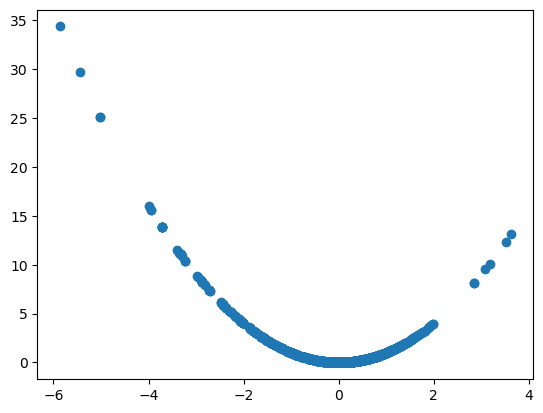

In [83]:
# Plot distance vs distance^2
plt.scatter(data=poly_train, x='distance_travelled(kms)', y='distance_travelled(kms)^2')

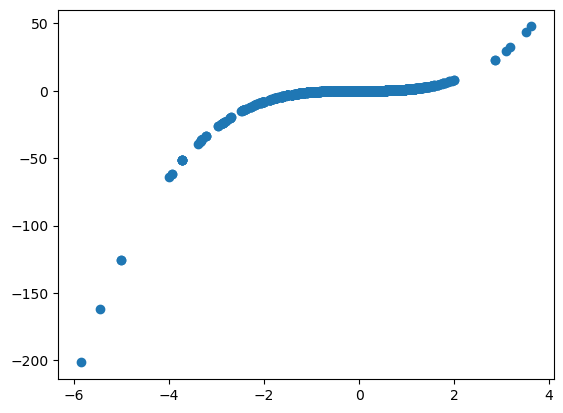

In [84]:
# Plot distance vs distance^2
plt.scatter(data=poly_train, x='distance_travelled(kms)', y='distance_travelled(kms)^3')

## Model with PolynomialFeatures

In [93]:
# instantiate transformers
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
# Instantiate the PolynomialFeatures transformer
poly = PolynomialFeatures(degree=2)

cat_cols = make_column_selector(dtype_include='object')
num_cols = make_column_selector(dtype_include='number')

# Add the PolynomialFeatures transformer to the numeric pipeline
num_pipe = make_pipeline(scaler, poly)

# create preprocessing pipeline
preprocess = make_column_transformer((ohe, cat_cols), (num_pipe, num_cols))

# Examine the results of all transformers
print(f"Shape before processing: {X_train.shape}")
print(f"Shape after processing: \
{preprocess.fit_transform(X_train, y_train).shape}")

Shape before processing: (1293, 6)
Shape after processing: (1293, 228)


In [94]:
# Create and evaluate model with PolynomialFeatures
poly_logreg = LogisticRegression(max_iter=1000)
poly_logreg_pipe = make_pipeline(preprocess, poly_logreg)
poly_logreg_pipe.fit(X_train, y_train)

train_pred = poly_logreg_pipe.predict(X_train)
test_pred = poly_logreg_pipe.predict(X_test)

PolyTrain 

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       901
           1       0.95      0.93      0.94       392

    accuracy                           0.96      1293
   macro avg       0.96      0.96      0.96      1293
weighted avg       0.96      0.96      0.96      1293



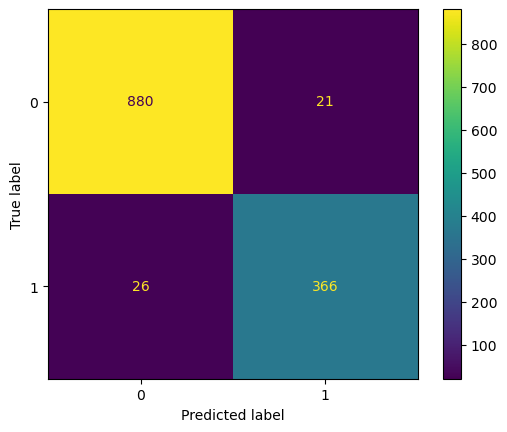

PolyTest 

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       300
           1       0.92      0.90      0.91       131

    accuracy                           0.95       431
   macro avg       0.94      0.93      0.94       431
weighted avg       0.95      0.95      0.95       431



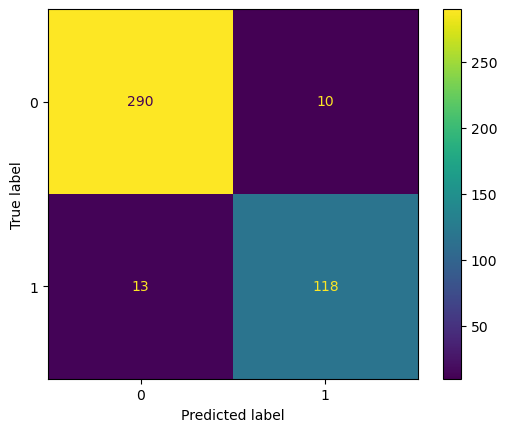

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
PolyTrain,0.945736,0.933673,0.939666,0.963650
PolyTest,0.921875,0.900763,0.911197,0.946636


In [95]:
# evaluate model
train_scores = eval_classification(y_train, train_pred, name='PolyTrain')

test_scores = eval_classification(y_test, test_pred, name='PolyTest')

poly_scores = pd.concat([train_scores, test_scores])
poly_scores

## Compare base and polynomial model scores

In [96]:
pd.concat([base_scores, poly_scores])

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
BaseTrain,0.945596,0.931122,0.938303,0.962877
BaseTest,0.921260,0.893130,0.906977,0.944316
PolyTrain,0.945736,0.933673,0.939666,0.963650
PolyTest,0.921875,0.900763,0.911197,0.946636


## What if we change the degree?